In [1]:
import os
import time
import functools

import numpy as np
from scipy import stats
from scipy.stats import uniform, norm, t as tdist, ttest_ind
import pandas as pd
import pickle


In [2]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib import rc

plt.rcParams['figure.figsize'] = 8, 3.5
plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['figure.dpi'] = 100;

# numpy print format
np.set_printoptions(linewidth=120, precision=4, suppress=False, formatter={'float': '{:5.3e}'.format})

In [3]:
import util.tests as tests
import util.dwdb_reader as io

import DpawsTools

In [4]:
# Converting correlation to pvalue
def r2pv(r, n):
    from scipy.stats.stats import _betai
    df = n - 2
    tsq = r**2 * (df / ((1.0 - r) * (1.0 + r)))
    return _betai(0.5*df, 0.5, df/(df+tsq))

In [5]:
small_value = 1e-300

PROJECT_ROOT_DIR="traces/CPA/trimmed3"
tracenum = 50000
step = 1000
repeats = 5
sample_start = 350 # 330
sample_end = 400 #360
rlen = sample_end - sample_start
DWDB_LOCATION = os.path.join(PROJECT_ROOT_DIR, "RandOnly_xorriro_lr_3_hw.dwdb")

IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
if not os.path.exists(IMAGES_PATH): os.makedirs(IMAGES_PATH)

LOG_DIR = os.path.join(PROJECT_ROOT_DIR, "log")
if not os.path.exists(LOG_DIR): os.makedirs(LOG_DIR)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load traces and predictions

In [6]:
print("Reading traces")
dsr = io.dwdb_reader(r'DPAD_AES.Traces/RawTraces.dwdb', r'DPAD_AES.Traces')
data_batch, meta_batch = dsr.read_batch(tracenum, sample_start, sample_end)
print("Done")

print("Processing data and meta")
data_np = np.asarray(data_batch)

#processing of classifiers
meta_prep = [m['other'].split() for m in meta_batch]
classifiers0 = [s.split('=')[1] for m in meta_prep for s in m if s.startswith('hw0=')]
classifiers0_np = np.vstack([c.split(',') for c in classifiers0]).astype(int)
classifiers3 = [s.split('=')[1] for m in meta_prep for s in m if s.startswith('hw3=')]
classifiers3_np = np.vstack([c.split(',') for c in classifiers3]).astype(int)
classifiers15 = [s.split('=')[1] for m in meta_prep for s in m if s.startswith('hw15=')]
classifiers15_np = np.vstack([c.split(',') for c in classifiers15]).astype(int)

nbytes = 3
all_classifiers = np.column_stack((classifiers0_np, classifiers3_np, classifiers15_np))
print("Done")

data_np.shape, classifiers0_np.shape

Reading traces
Done
Processing data and meta
Done


((50000L, 50L), (50000L, 256L))

## Sanity check

In [7]:
bincor = DpawsTools.Bincor(data_np.shape[1], all_classifiers.shape[1])
bincor.process(data_np, all_classifiers)


In [8]:
fzt = functools.partial(DpawsTools.FisherTransformation, tracenum)

fzscores = np.vstack(bincor.correlation())
[fzt(_cc) for _c in [fzscores] for _cc in _c];
fzscores = fzscores.reshape(3, 256, -1)

In [9]:
# threshold = 7.0
# lk0b, lk0pt = np.where(np.abs(fzscores[0]) > threshold)
# print(lk0pt, fzscores[0,lk0pt])


<IPython.core.display.Javascript object>


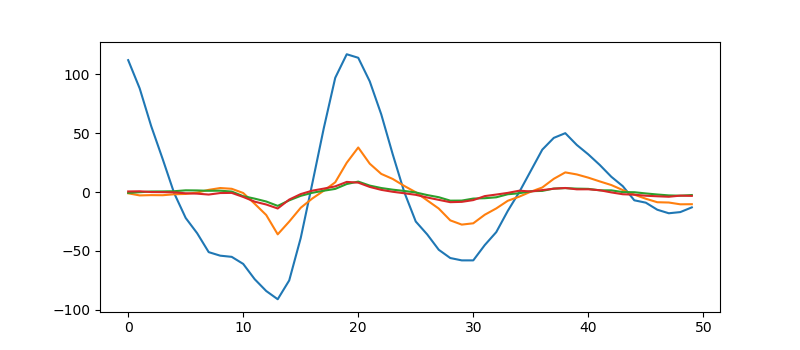

In [10]:
fig = plt.figure()
plt.plot(data_np[0])
plt.plot(fzscores[0][0xBC]) # byte 0 (pt 70)
plt.plot(fzscores[1][0x5C]) # byte 3 (pt 70)
plt.plot(fzscores[2][0x4A]) # byte 15 (pt 69)
plt.show()

In [11]:
byte_idx = {0:0, 3:1, 15:2, 5: 3}
byte_pt = {0:20, 3:20, 15:19, 5: 3}
key_idx = {0:0xBC, 3:0x5C, 5: 0xE4, 15:0x4A}


## Evolution

In [12]:
tstat_evo = []
xx = np.arange(tracenum).reshape(-1, step)
bincor = DpawsTools.Bincor(data_np.shape[1], all_classifiers.shape[1])
for x in xx:
    bincor.process(data_np[x], all_classifiers[x])
    fzscores = np.vstack(bincor.correlation())
    [DpawsTools.FisherTransformation(bincor.count(), _cc) for _c in [fzscores] for _cc in _c]
    fzscores = fzscores.reshape(3, 256, -1)
    tstat_evo.append(fzscores)
tstat_evo = np.array(tstat_evo)
tstat_evo.shape

(50L, 3L, 256L, 50L)

<IPython.core.display.Javascript object>


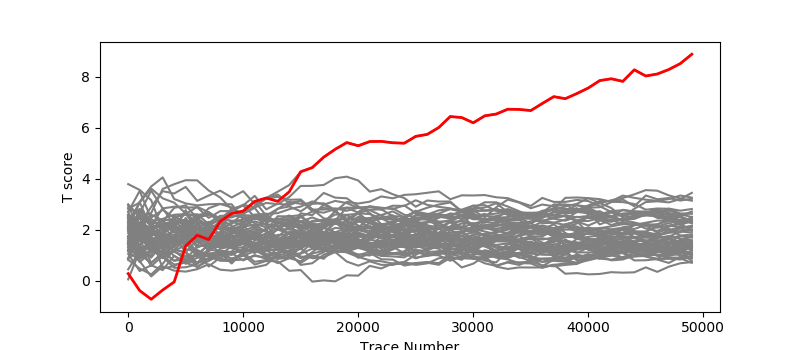

In [13]:
pb = 3
hw_num = tstat_evo.shape[2]

x_axis = np.arange(len(tstat_evo)) * step

fig = plt.figure()
plt.ylabel('T score')
plt.xlabel('Trace Number')

for j in range(0, hw_num, 4):
    mtt = np.max(tstat_evo[:, byte_idx[pb], j], axis=1)
    plt.plot(x_axis, mtt, linewidth=1.5, linestyle='-', color = 'grey', zorder = j)
ml_pt = np.argmax(tstat_evo[-1, byte_idx[pb], key_idx[pb]]) # max leak point
plt.plot(x_axis, tstat_evo[:, byte_idx[pb], key_idx[pb], ml_pt], linewidth=2, linestyle='-', color = 'r', zorder=255)

plt.show()


## Debugging at 20k


In [14]:
%%script false    # This line is to skip this cell as a whole
# rp_full_per_step = []  # rpv
# t_full_per_step = []   # t
# tp_full_per_step = []  # tpv

pb = 0
bootidx = 15

pb = 0
pi = 19 #byte_pt[pb]
bi = byte_idx[pb]
hwi = key_idx[pb]   # kpv = 0

plot_evo = t_full_per_step[:,bootidx,:,pi].reshape(-1, 3, 256)

x_axis = (np.arange(len(plot_evo)) + 1) * step

fig = plt.figure()
plt.xlabel('Trace Number')
plt.ylabel('T score')

hw_num = plot_evo.shape[2]
for j in range(0, hw_num, 4):
    mtt = plot_evo[:, byte_idx[pb], j]
    plt.plot(x_axis, mtt, linewidth=0.5, color = 'grey', zorder = j)
plt.plot(x_axis, plot_evo[:, byte_idx[pb], key_idx[pb]], linewidth=1, color = 'r', zorder=255)

plt.show()


Couldn't find program: u'false'


## Bootstrapping

In [15]:
boots = 200
step = 5000
upper_bnd = 20000 #tracenum
r_full_per_step = []
rp_full_per_step = []
t_full_per_step = []
tp_full_per_step = []
for rangenum in range(step, upper_bnd+1, step):
    r_full, rp_full, t_full, tp_full = [], [], [], []
    start = time.time()
    boot_idxs = np.random.randint(rangenum, size=(boots, rangenum))
    print("attacking on {} traces, shape {}".format(rangenum, boot_idxs.shape))
    for bi in boot_idxs:
        bincor = DpawsTools.Bincor(data_np.shape[1], all_classifiers.shape[1])
        bincor.process(data_np[bi], all_classifiers[bi])
        n = bincor.count()
        ps_per_boot = np.vstack(bincor.correlation())  # for all hws do the following:
        r_full.append(ps_per_boot.copy())
#         mr = np.max(ps_per_boot, axis=1)                   # find max corr from the range
#         mpv = r2pv(mr, n)                                  # convert r to pv
        mpv = [r2pv(_cc, n) for _c in [ps_per_boot] for _cc in _c]
        rp_full.append(mpv)
#         DpawsTools.FisherTransformation(n, mr)             # convert r to t-score
        [DpawsTools.FisherTransformation(n, _cc) for _c in [ps_per_boot] for _cc in _c]
        t_full.append(ps_per_boot)
#         tpv = tdist.sf(mr.copy(), n)                       # convert t-score to pv 
        tpv = [tdist.sf(_cc, n) for _c in [ps_per_boot] for _cc in _c]
        tp_full.append(tpv)
    r_full_per_step.append(r_full)
    rp_full_per_step.append(rp_full)
    t_full_per_step.append(t_full)
    tp_full_per_step.append(tp_full)
    print("Done in {}".format(time.time() - start))
r_full_per_step = np.array(r_full_per_step)
rp_full_per_step = np.array(rp_full_per_step)
t_full_per_step = np.array(t_full_per_step)
tp_full_per_step = np.array(tp_full_per_step)

attacking on 5000 traces, shape (200L, 5000L)
Done in 39.0439999104
attacking on 10000 traces, shape (200L, 10000L)
Done in 46.4119999409
attacking on 15000 traces, shape (200L, 15000L)
Done in 54.495000124
attacking on 20000 traces, shape (200L, 20000L)
Done in 62.7490000725


In [16]:
r_full_per_step.shape

(4L, 200L, 768L, 50L)

d, pv, l, s, non_uniform
[[9.766e-01 0.000e+00 -2.445e-02 4.782e-02 1.000e+00]
 [9.746e-01 0.000e+00 -2.143e-02 4.680e-02 1.000e+00]
 [9.476e-01 0.000e+00 5.742e-03 4.663e-02 1.000e+00]]


<IPython.core.display.Javascript object>


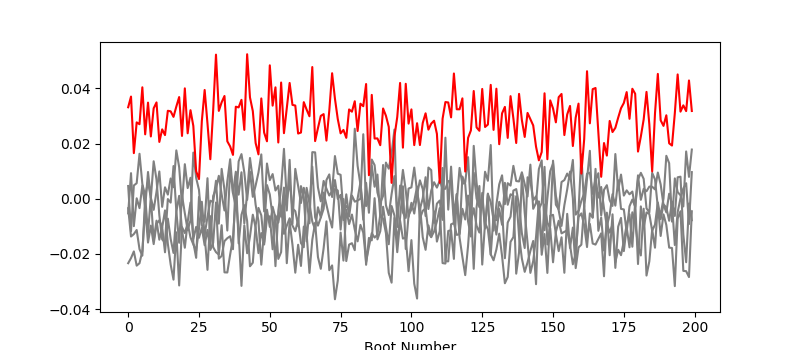

In [30]:
# r_full_per_step  = []  # source r
# rp_full_per_step = []  # rpv
# t_full_per_step  = []  # t
# tp_full_per_step = []  # tpv

# Right bytes (answer) 0:0xBC, 3:0x5C, 5: 0xE4

pb = 3
pi = 20 #byte_pt[pb]
bi = byte_idx[pb]
hwi = key_idx[pb]   # ks pv = 0, but also for 32, 56, 112 (byte 3, step 2)
si = 2

bpvs = r_full_per_step[si].T[pi].reshape(3, 256, -1)[bi]

kpvs = []
leak_dist = stats.uniform
# leak_dist = stats.norm
for j in range(0, len(bpvs), 128):
    bcorr = bpvs[j]
    d, pv = stats.kstest(bcorr, leak_dist().cdf)
    l, s = leak_dist.fit(bcorr)
    non_uniform = pv < 0.05
    kpvs.append([d, pv, l, s, non_uniform])
d, pv = stats.kstest(bpvs[hwi], leak_dist().cdf)
l, s = leak_dist.fit(bpvs[hwi])
non_uniform = pv < 0.05
kpvs.append([d, pv, l, s, non_uniform])

print("d, pv, l, s, non_uniform")
print(np.array(kpvs))
    
# norm_cdf = norm(loc=0, scale=1).cdf
# dt, pv  = stats.kstest(bpvs, norm_cdf)

fig = plt.figure()
plt.xlabel('Boot Number')
for j in range(0, len(bpvs), 64):
    plt.plot(bpvs[j], color = 'grey', zorder = j)
plt.plot(bpvs[hwi], color = 'r', zorder=255)
plt.show()

In [18]:
# Whether it follows the uniform distribution? (The longest part)
ld_stat = stats.uniform
ld_cdf = ld_stat().cdf
ksp_per_step = np.zeros_like(rp_full_per_step[:,1])

for s, bps in enumerate(rp_full_per_step):          # step
    bpsr = bps.T                                    # -> (pv, hwi, boot)
    start = time.time()
    print('{}: Step {} ...'.format(bpsr.shape, s))
    for i, ptwt in enumerate(bpsr):
#         ptwt = ptwt.reshape(3, 256, -1)[bi]
        for j in range(len(ptwt)):
            d, kpv = stats.kstest(ptwt[j], ld_cdf)
#             print(d, kpv)
            ksp_per_step[s, j, i] = kpv
    print("Done in {}".format(time.time() - start))


(50L, 768L, 200L): Step 0 ...
Done in 10.0969998837
(50L, 768L, 200L): Step 1 ...
Done in 9.66899991035
(50L, 768L, 200L): Step 2 ...
Done in 9.60800004005
(50L, 768L, 200L): Step 3 ...
Done in 9.63899993896


In [19]:
# Visualization
pb = 15
pi = byte_pt[pb]
bi = byte_idx[pb]
hwi = key_idx[pb]   # kpv = 0
# hwi = 5           # kpv = 0
plot_evo = ksp_per_step.T[pi].reshape(3, 256, -1)[bi].copy()

plot_evo[np.where(plot_evo < small_value)] = small_value

<IPython.core.display.Javascript object>


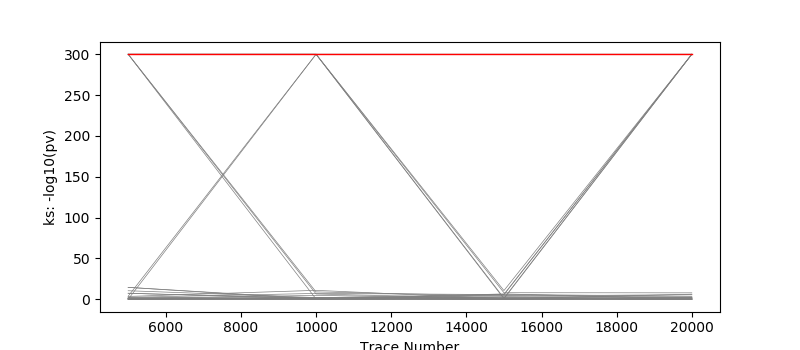

74


In [20]:
hw_num = plot_evo.shape[0]

x_axis = (np.arange(len(plot_evo.T)) + 1) * step

fig = plt.figure()
plt.xlabel('Trace Number')
plt.ylabel('ks: -log10(pv)')

print(hwi)

for j in range(0, hw_num, 8):
    mtt = -np.log10(plot_evo[j])
#     print(j, mtt)
    plt.plot(x_axis, mtt, linewidth=0.5, color = 'grey', zorder = j)
khw = -np.log10(plot_evo[hwi])
plt.plot(x_axis, khw, linewidth=1, color = 'r', zorder=255)

plt.show()
# plot_evo.shape, x_axis.shape

In [21]:
pb = 3
pi = 20 #byte_pt[pb]
bi = byte_idx[pb]
hwi = key_idx[pb]   # kpv = 0
# hwi = 5           # kpv = 0
bootidx = 15
si = 2

bpvs = rp_full_per_step[si].T[pi].reshape(3, 256, -1)[bi]
# print(bpvs[hwi].shape, stats.kstest(bpvs[hwi], ld_cdf))

In [22]:
ud = uniform(loc=0, scale=1)
for i in range(3):
    udrv = ud.rvs(size=1000)
    dk, kpv = stats.kstest(udrv, 'uniform') # H0 - data is uniform
    non_uniform = kpv < 0.05
    print(dk, kpv, non_uniform)

(0.020271580038795922, 0.8057421218625676, False)
(0.022745269469681834, 0.6789656501578599, False)
(0.023398569518338408, 0.6441413299179729, False)


In [23]:
x_100 = norm.rvs(loc=10, scale=1, size=100)
nd = norm(loc=0, scale=1)
for i in range(3):
    ndrv = nd.rvs(size=100)
    dn, npv = stats.kstest(ndrv, 'norm') # H0 - data is norm
    non_norm = npv < 0.05
    print(dn, npv, non_norm)

(0.07534739432713611, 0.611729704992958, False)
(0.10709947748723764, 0.18763838355660667, False)
(0.06440307825546909, 0.8011954478599529, False)


In [24]:
nd_cdf = norm(loc=10, scale=1).cdf
for i in range(3):
    ndrv = norm.rvs(loc=10, scale=1, size=100)
    dn, npv = stats.kstest(ndrv, nd_cdf) # H0 - data is norm
    non_norm = npv < 0.05
    print(dn, npv, non_norm)

(0.08823838033022063, 0.3976494145631235, False)
(0.10117190205878773, 0.2413044626110159, False)
(0.06960416270738445, 0.7253475529792639, False)


In [25]:
n = 100
a = np.random.random(size=(n, 2)) * 10.0
b = np.random.randint(0, 10, size=(n, 1), dtype=np.uint8)
a[:,0] += b[:,0] / 2.0

bincor = DpawsTools.Bincor(2, 1)
bincor.process(a, b)
rr = np.vstack(bincor.correlation())
pr = np.vstack([r2pv(r, n) for r in rr.copy()])
tt = np.vstack([DpawsTools.FisherTransformation(n, r) for r in rr.copy()])
tt2 = [DpawsTools.FisherTransformation(bincor.count(), _cc) for _c in [rr.copy()] for _cc in _c]
pt = np.vstack([tdist.sf(t1, n) for t1 in tt])

print(rr)
print(tt)
print(tt2)
print(pr) # p-val from r
print(pt) # p-val from t-stat


[[5.206e-01 -2.253e-01]]
[[5.685e+00 -2.258e+00]]
[array([5.685e+00, -2.258e+00])]
[[2.817e-08 2.420e-02]]
[[6.499e-08 9.869e-01]]
